In [140]:
## analyse the data
import mne
import numpy as np
import matplotlib.pyplot as plt
import glob

from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
raw=mne.io.read_raw_gdf('BCICIV_2a_gdf/A01E.gdf',
                         eog=['EOG-left', 'EOG-central', 'EOG-right'])
raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])

Extracting EDF parameters from C:\Users\uabhi\NEW_MY_JUPYTER\BCI\BCI 4 dataset\BCICIV_2a_gdf\A01E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...


C:\Users\uabhi\anaconda3\envs\tf\lib\site-packages\mne\io\edf\edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
C:\Users\uabhi\anaconda3\envs\tf\lib\contextlib.py:120: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


<RawGDF | A01E.gdf, 22 x 687000 (2748.0 s), ~26 kB, data not loaded>

In [108]:
def read_data(path):
    raw=mne.io.read_raw_gdf(path,preload=True,
                          eog=['EOG-left', 'EOG-central', 'EOG-right'])
    raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])
    raw.set_eeg_reference()
    events=mne.events_from_annotations(raw)
    epochs = mne.Epochs(raw, events[0], event_id=[7,8],tmin= 2, tmax=4,baseline=(None,4), on_missing ='warn')
    labels=epochs.events[:,-1]
    features=epochs.get_data()
    return features,labels

In [109]:
paths = glob.glob('BCICIV_2a_gdf/*.gdf')

In [110]:
%%capture
features,labels,groups=[],[],[]
paths = glob.glob('BCICIV_2a_gdf/*.gdf')
for i in paths:
    feature,label=read_data(i)
    features.append(feature)
    labels.append(label)
    groups.append([i]*len(label))

In [111]:
features=np.concatenate(features)
labels=np.concatenate(labels)
groups=np.concatenate(groups)

features.shape,labels.shape,groups.shape

((3888, 22, 501), (3888,), (3888,))

In [112]:
unique, counts = np.unique(groups, return_counts=True)
unique, counts

(array(['BCICIV_2a_gdf\\A01E.gdf', 'BCICIV_2a_gdf\\A01T.gdf',
        'BCICIV_2a_gdf\\A02E.gdf', 'BCICIV_2a_gdf\\A02T.gdf',
        'BCICIV_2a_gdf\\A03E.gdf', 'BCICIV_2a_gdf\\A03T.gdf',
        'BCICIV_2a_gdf\\A04E.gdf', 'BCICIV_2a_gdf\\A04T.gdf',
        'BCICIV_2a_gdf\\A05E.gdf', 'BCICIV_2a_gdf\\A05T.gdf',
        'BCICIV_2a_gdf\\A06E.gdf', 'BCICIV_2a_gdf\\A06T.gdf',
        'BCICIV_2a_gdf\\A07E.gdf', 'BCICIV_2a_gdf\\A07T.gdf',
        'BCICIV_2a_gdf\\A08E.gdf', 'BCICIV_2a_gdf\\A08T.gdf',
        'BCICIV_2a_gdf\\A09E.gdf', 'BCICIV_2a_gdf\\A09T.gdf'], dtype='<U22'),
 array([288, 144, 288, 144, 288, 144, 288, 144, 288, 144, 288, 144, 288,
        144, 288, 144, 288, 144], dtype=int64))

# Chronet

In [113]:
from sklearn.model_selection import GroupKFold,LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
gkf=GroupKFold()
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.preprocessing import StandardScaler
#https://stackoverflow.com/questions/50125844/how-to-standard-scale-a-3d-matrix
class StandardScaler3D(BaseEstimator,TransformerMixin):
    #batch, sequence, channels
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self,X,y=None):
        self.scaler.fit(X.reshape(-1, X.shape[2]))
        return self

    def transform(self,X):
        return self.scaler.transform(X.reshape( -1,X.shape[2])).reshape(X.shape)

In [114]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [115]:
lb = preprocessing.LabelBinarizer()

#enc_df= enc.fit_transform(dataset['60'])
labels =  lb.fit_transform(labels)

In [116]:
np.unique(labels)

array([0, 1])

In [149]:
data_array = features
label_array = labels
group_array = groups
data_array=np.moveaxis(data_array,1,2)

In [150]:
scaler=StandardScaler3D()
train_features,val_features,train_labels,val_labels = train_test_split(data_array, label_array, test_size=0.33, random_state=42)
train_features=scaler.fit_transform(train_features)
val_features=scaler.transform(val_features)

In [151]:
train_features.shape, train_labels.shape

((2604, 501, 22), (2604, 1))

# ChronoNet

In [152]:
from tensorflow.keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D,Dropout,BatchNormalization
from tensorflow.keras.models import Model
#resource:https://github.com/dll-ncai/eeg_pre-diagnostic_screening/blob/master/code/chro

In [153]:
def block(input, dropout_rate):
    conv1 = Conv1D(32, 2, strides=2,activation='relu',padding="same")(input)
    conv1 = Dropout(dropout_rate)(conv1)
    conv1 = BatchNormalization()(conv1)
    
    conv2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(input)
    conv2 = Dropout(dropout_rate)(conv2)
    conv2 = BatchNormalization()(conv2)
    
    conv3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(input)
    conv3 = Dropout(dropout_rate)(conv3)
    conv3 = BatchNormalization()(conv3)
    x = concatenate([conv1,conv2,conv3],axis=2)
    return x

In [159]:
input= Input(shape=(train_features.shape[1],train_features.shape[2]))
dropout_rate = 0.4
block1=block(input, dropout_rate)
block2=block(block1, dropout_rate)
block3=block(block2, dropout_rate)
block3.shape

TensorShape([None, 63, 96])

In [160]:
gru_out1 = GRU(32,activation='tanh',return_sequences=True)(block3)
gru_out2 = GRU(32,activation='tanh',return_sequences=True)(gru_out1)
gru_out = concatenate([gru_out1,gru_out2],axis=2)
gru_out3 = GRU(32,activation='tanh',return_sequences=True)(gru_out)
gru_out = concatenate([gru_out1,gru_out2,gru_out3])
gru_out4 = GRU(32,activation='tanh')(gru_out)

In [161]:
predictions = Dense(train_labels.shape[1] ,activation='sigmoid')(gru_out4)
model = Model(inputs=input, outputs=predictions)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [162]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 501, 22)]    0           []                               
                                                                                                  
 conv1d_45 (Conv1D)             (None, 251, 32)      1440        ['input_6[0][0]']                
                                                                                                  
 conv1d_46 (Conv1D)             (None, 251, 32)      2848        ['input_6[0][0]']                
                                                                                                  
 conv1d_47 (Conv1D)             (None, 251, 32)      5664        ['input_6[0][0]']                
                                                                                            

                                                                                                  
 concatenate_28 (Concatenate)   (None, 63, 64)       0           ['gru_20[0][0]',                 
                                                                  'gru_21[0][0]']                 
                                                                                                  
 gru_22 (GRU)                   (None, 63, 32)       9408        ['concatenate_28[0][0]']         
                                                                                                  
 concatenate_29 (Concatenate)   (None, 63, 96)       0           ['gru_20[0][0]',                 
                                                                  'gru_21[0][0]',                 
                                                                  'gru_22[0][0]']                 
                                                                                                  
 gru_23 (G

In [163]:
chrono_history = model.fit(train_features,train_labels,epochs=50,batch_size=10,validation_data=(val_features,val_labels))

Epoch 1/50
261/261 [==============================] - 50s 144ms/step - loss: 0.4762 - accuracy: 0.8199 - val_loss: 0.4339 - val_accuracy: 0.8403
Epoch 2/50
261/261 [==============================] - 36s 136ms/step - loss: 0.4540 - accuracy: 0.8295 - val_loss: 0.4335 - val_accuracy: 0.8403
Epoch 3/50
261/261 [==============================] - 35s 135ms/step - loss: 0.4518 - accuracy: 0.8299 - val_loss: 0.4575 - val_accuracy: 0.8372
Epoch 4/50
261/261 [==============================] - 35s 134ms/step - loss: 0.4486 - accuracy: 0.8299 - val_loss: 0.4390 - val_accuracy: 0.8403
Epoch 5/50
261/261 [==============================] - 35s 134ms/step - loss: 0.4451 - accuracy: 0.8299 - val_loss: 0.4309 - val_accuracy: 0.8411
Epoch 6/50
261/261 [==============================] - 35s 134ms/step - loss: 0.4371 - accuracy: 0.8299 - val_loss: 0.4322 - val_accuracy: 0.8403
Epoch 7/50
261/261 [==============================] - 36s 137ms/step - loss: 0.4377 - accuracy: 0.8276 - val_loss: 0.4487 - val_ac

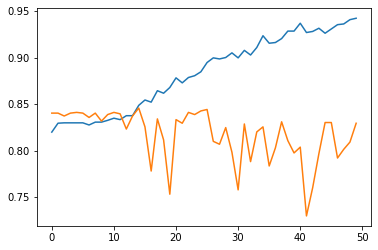

In [168]:
plt.plot(chrono_history.history["accuracy"])
plt.plot(chrono_history.history["val_accuracy"])

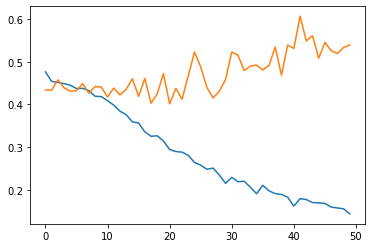

In [169]:
plt.plot(chrono_history.history["loss"])
plt.plot(chrono_history.history["val_loss"])

# Binary Class Class accuaracies

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2161
           1       0.98      0.98      0.98       443

    accuracy                           0.99      2604
   macro avg       0.99      0.99      0.99      2604
weighted avg       0.99      0.99      0.99      2604



<AxesSubplot:>

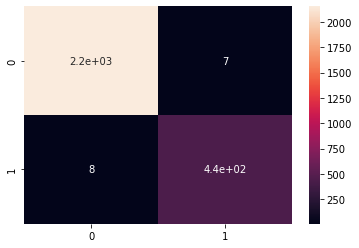

In [170]:
# classification report on training set
y_p = []
pred = model.predict_on_batch(train_features)
pred = pred.reshape(pred.shape[0])
for l in pred:
    if l>0.5:
        y_p.append(1)
    else:
        y_p.append(0)
y_t = train_labels.reshape(train_labels.shape[0])
print(classification_report(y_t, y_p))
cf_matrix = confusion_matrix(y_t, y_p)
sns.heatmap(cf_matrix, annot=True)

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1079
           1       0.45      0.33      0.38       205

    accuracy                           0.83      1284
   macro avg       0.67      0.63      0.64      1284
weighted avg       0.81      0.83      0.82      1284



<AxesSubplot:>

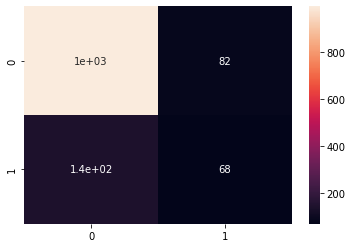

In [172]:
# classification report on validation set
y_p = []
pred = model.predict_on_batch(val_features)
pred = pred.reshape(pred.shape[0])
for l in pred:
    if l>0.5:
        y_p.append(1)
    else:
        y_p.append(0)
y_t = val_labels.reshape(val_labels.shape[0])
print(classification_report(y_t, y_p))
cf_matrix = confusion_matrix(y_t, y_p)
sns.heatmap(cf_matrix, annot=True)

# Multiclass class accuracies

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1284

    accuracy                           1.00      1284
   macro avg       1.00      1.00      1.00      1284
weighted avg       1.00      1.00      1.00      1284



<AxesSubplot:>

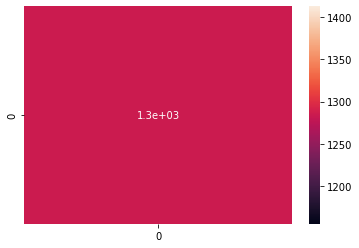

In [166]:
y_t = np.argmax(val_labels, axis=1) # Convert one-hot to index
pred = model.predict_on_batch(val_features)
y_p = np.argmax(pred,axis=1)
print(classification_report(y_t, y_p))
cf_matrix = confusion_matrix(y_t, y_p)
sns.heatmap(cf_matrix, annot=True)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2604

    accuracy                           1.00      2604
   macro avg       1.00      1.00      1.00      2604
weighted avg       1.00      1.00      1.00      2604



<AxesSubplot:>

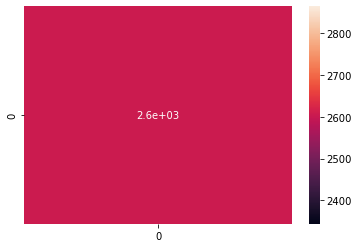

In [167]:
y_t = np.argmax(train_labels, axis=1) # Convert one-hot to index
pred = model.predict_on_batch(train_features)
y_p = np.argmax(pred,axis=1)
print(classification_report(y_t, y_p))
cf_matrix = confusion_matrix(y_t, y_p)
sns.heatmap(cf_matrix, annot=True)

In [85]:
y_p = model.predict_on_batch(val_features)

In [96]:
np.count_nonzero(val_labels)

199